In [72]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sklearn as sk
from sklearn import decomposition as dec
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune
import sklearn.manifold as nonlin
import copy


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

trainloader_mnist = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                shuffle=True, num_workers=2)
testloader_mnist = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                               shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [98]:
mnist_dataset_sample = iter(testloader_mnist)
sample_im, sample_lbl = mnist_dataset_sample.next()

cifar_dataset_sample = iter(testloader)
sample_im_c, sample_lbl_c = cifar_dataset_sample.next()


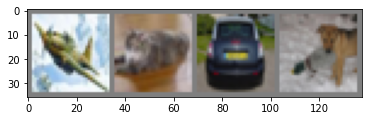

plane cat   car   dog  


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# function to use later 

In [ ]:
def are_weights(model,weights):
    w1,w2,w3 = weights
    model.fc1.weight.data = w1
    model.fc2.weight.data = w2
    model.fc3.weight.data = w3
    return model


def construct_model(model, layers):
    l1, l2, l3 = layers
    model.fc1 = l1
    model.fc2 = l2
    model.fc3 = l3
    return model
    
def change_dimensionality(weight, dr_method):
    x1 = weight.detach().numpy().T
    x1 = dr_method.fit_transform(x1)
    x1 = torch.tensor(x1.T, dtype=torch.float32)
    print("x_new vector")
    print(x1.shape)
    return x1

    

In [8]:
def average_accuracy(net, dataset):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataset:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # again no gradients needed
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


In [6]:
from torch.profiler import profile, record_function, ProfilerActivity
import torch.optim as optim


def training(model, trainset, n):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    running_loss = 0.0
    total = 0.0
    correct = 0.0
    loss_nodr = []
    acc_nodr = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print(optimizer)

    for epoch in range(n):

        print('epoch:', epoch)
        for i, data in enumerate(trainset):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad(True)
            with torch.set_grad_enabled(True):
                with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
                 outputs = model(inputs).to(device)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            running_loss += loss.item()
            if i % 2000 == 1999:
                loss_temp = running_loss / 2000
                acc_temp = 100 * correct / total
                loss_nodr.append(loss_temp)
                acc_nodr.append(acc_temp)
                print(
                    f'[{epoch + 1}, {i + 1:5d}] loss: {loss_temp:.3f} acc: {acc_temp:.3f}')
                running_loss = 0.0
                correct = 0.0
                total = 0.0
    print('Finished Training')


# Dimensional reduction on Mnist dataset

In [10]:
class NN(nn.Module):
    def __init__(self, is_normalize):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=12, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2), stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=(5, 5))
        self.fc1 = nn.Linear(256, 120) # 256x 60
        self.fc2 = nn.Linear(120, 84) # 60 x 84
        self.fc3 = nn.Linear(84, 10)
        self.soft = nn.Softmax(dim=0)
        self.norm = is_normalize

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if(self.norm==True):
         x = nn.functional.normalize(self.fc3(x))
        else:
         x = self.fc3(x)
         
        # x = self.soft(x)
        return x
    

### Training of the network

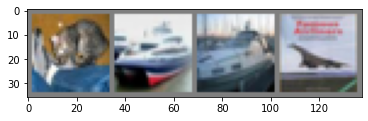

cat
ship
ship
plane


In [7]:
test_data = iter(testloader)
images_test, labels_test = test_data.next()


imshow(torchvision.utils.make_grid(images_test))

for a in labels_test:
    print(classes[a])

In [34]:
the_output = net(images_test)

acc, lb_pred = torch.max(the_output, 1)
print(lb_pred)



tensor([3, 8, 1, 8])


In [35]:
for i in lb_pred:
    print('Predicted: {}'.format(classes[i]))


Predicted: cat
Predicted: ship
Predicted: car
Predicted: ship


In [106]:
net.state_dict = dr_dic


In [107]:
for key in dr_dic:
    print(key)

conv1.weight
conv2.weight
fc1.weight
fc2.weight
fc3.weight


TESTING NETWORK WITH DIMEMSNIOALLY REDUCED NETWORK 

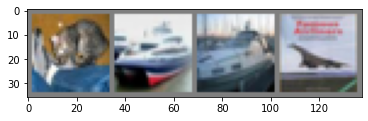

cat
ship
ship
plane


In [115]:

imshow(torchvision.utils.make_grid(images_test))

for a in labels_test:
    print(classes[a])


In [220]:
original_network = NN(is_normalize=True)


In [221]:
training(original_network, trainloader_mnist,5)
pca_original_network_path = './pca_reduced_networks/mnist/pca_original_network.pt'
torch.save(original_network,pca_original_network_path)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
epoch: 0
[1,  2000] loss: 1.624 acc: 85.162
[1,  4000] loss: 1.476 acc: 96.362
[1,  6000] loss: 1.462 acc: 96.825
[1,  8000] loss: 1.456 acc: 97.287
[1, 10000] loss: 1.452 acc: 97.425
[1, 12000] loss: 1.446 acc: 97.763
[1, 14000] loss: 1.445 acc: 97.950
epoch: 1
[2,  2000] loss: 2.163 acc: 98.183
[2,  4000] loss: 1.440 acc: 98.225
[2,  6000] loss: 1.439 acc: 98.562
[2,  8000] loss: 1.436 acc: 98.725
[2, 10000] loss: 1.438 acc: 98.237
[2, 12000] loss: 1.438 acc: 98.325
[2, 14000] loss: 1.438 acc: 98.325
epoch: 2
[3,  2000] loss: 2.151 acc: 98.717
[3,  4000] loss: 1.437 acc: 98.425
[3,  6000] loss: 1.433 acc: 98.850
[3,  8000] loss: 1.435 acc: 98.650
[3, 10000] loss: 1.433 acc: 98.838
[3, 12000] loss: 1.435 acc: 98.562
[3, 14000] loss: 1.434 acc: 98.638
epoch: 3
[4,  2000] loss: 2.148 acc: 98.883
[4,  4000] loss: 1.432 acc: 98.838
[4,  6

In [262]:
average_accuracy(original_network, testloader_mnist)

Accuracy of the network on the 10000 test images: 98 %


In [223]:
output = original_network(sample_im)
_,pred = torch.max(output, dim=1)
print(sample_lbl)
print(pred)

tensor([9, 0, 1, 3])
tensor([9, 0, 1, 3])


In [249]:
path = './pca_reduced_networks/mnist/pca_original_network.pt'
original_network = torch.load(path)
original_network.eval()


NN(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (soft): Softmax(dim=0)
)

## dimensional reduction of the original network without retraining

In [448]:
def drprojection(model, method):
    weight_list = []
    weight1 = model.fc1.weight
    print('fc1 layer weight')

   
    fc1_reduced = change_dimensionality(weight1, method(n_components=int(weight1.shape[0]/2)))
    weight_list.append(fc1_reduced)
    x2 = torch.mm(model.fc1.weight, fc1_reduced.T)
    print(x2.shape)
    weight2 = torch.mm(model.fc2.weight, x2)
    print(weight2.shape)

    fc2_reduced = change_dimensionality(weight2,method(n_components=int(weight2.shape[0]/2)))
    print('fc2 layer weight')
    print(fc2_reduced.shape)
    weight_list.append(fc2_reduced)



    x3_reduced = torch.mm(weight2, fc2_reduced.T)

    fc3_reduced = torch.mm(model.fc3.weight, x3_reduced)
    print('fc3 layer weight')
    print(fc3_reduced.shape)
    weight_list.append(fc3_reduced)

    return weight_list



In [33]:
weight1 = original_network.fc1.weight
print('fc1 layer weight')

fc1_reduced = change_dimensionality(weight1, dec.PCA(n_components=int(weight1.shape[0]/2)))

x2 = torch.mm(original_network.fc1.weight, fc1_reduced.T)
print(x2.shape)
weight2 = torch.mm(original_network.fc2.weight, x2)
print(weight2.shape)

fc2_reduced = change_dimensionality(weight2, dec.PCA(n_components=int(weight2.shape[0]/2)))
print('fc2 layer weight')
print(fc2_reduced.shape)




x3_reduced = torch.mm(weight2, fc2_reduced.T)

fc3_reduced =  torch.mm(original_network.fc3.weight, x3_reduced)
print('fc3 layer weight')
print(fc3_reduced.shape)


fc1 layer weight
x_new vector
torch.Size([60, 256])
torch.Size([120, 60])
torch.Size([84, 60])
x_new vector
torch.Size([42, 60])
fc2 layer weight
torch.Size([42, 60])
fc3 layer weight
torch.Size([10, 42])


In [570]:
biasfc1 = original_network.fc1.bias.detach().numpy()
dd = dec.PCA(n_components=6)
biasfc1 = biasfc1.reshape(-1, 12)
biasfc1 = dd.fit_transform(biasfc1)
biasfc1 = torch.tensor(biasfc1.flatten())
print(biasfc1.shape)

biasfc2 = original_network.fc2.bias.detach().numpy()
dd = dec.PCA(n_components=6)
biasfc2 = biasfc2.reshape(-1, 12)
biasfc2 = dd.fit_transform(biasfc2)
biasfc2 = torch.tensor(biasfc2.flatten())
print(biasfc2.shape)


biasfc3 = original_network.fc3.bias
print(biasfc3.shape)

torch.Size([60])
torch.Size([42])
torch.Size([10])


In [590]:
layers = (nn.Linear(256, 60), nn.Linear(60, 42), nn.Linear(42, 10))
weights = drprojection(original_network, dec.PCA)
dr_mnist_network_untrained = copy.deepcopy(original_network)
dr_mnist_network_untrained = construct_model(dr_mnist_network_untrained,layers)
dr_mnist_network_untrained = are_weights(dr_mnist_network_untrained, tuple(weights))
dr_mnist_network_untrained.fc1.bias.data = biasfc1
dr_mnist_network_untrained.fc2.bias.data = biasfc2
dr_mnist_network_untrained.fc3.bias.data = biasfc3
dr_mnist_network_untrained.eval()

fc1 layer weight
x_new vector
torch.Size([60, 256])
torch.Size([120, 60])
torch.Size([84, 60])
x_new vector
torch.Size([42, 60])
fc2 layer weight
torch.Size([42, 60])
fc3 layer weight
torch.Size([10, 42])


NN(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=10, bias=True)
  (soft): Softmax(dim=0)
)

In [591]:
average_accuracy(dr_mnist_network_untrained, testloader_mnist)

Accuracy of the network on the 10000 test images: 28 %


In [578]:
output = dr_mnist_network_untrained(sample_im)

_,pred = torch.max(output, dim=1)
print(sample_lbl)
print(pred)

tensor([9, 0, 1, 3])
tensor([9, 9, 1, 9])


In [452]:
path_dr_mnist_network_untrained = './pca_reduced_networks/mnist/dr_mnist_network_untrained.pt'
torch.save(dr_mnist_network_untrained, path_dr_mnist_network_untrained)


## retraining dimensionally reduced network

In [453]:
dr_mnist_network_retrained = copy.deepcopy(dr_mnist_network_untrained)

In [454]:
training(dr_mnist_network_retrained, trainloader_mnist, 5)


SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
epoch: 0


c:\Users\sulta\anaconda3\lib\site-packages\torch\autograd\profiler.py:160: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[1,  2000] loss: 1.691 acc: 84.900
[1,  4000] loss: 1.561 acc: 95.537
[1,  6000] loss: 1.518 acc: 97.112
[1,  8000] loss: 1.499 acc: 97.312
[1, 10000] loss: 1.485 acc: 97.612
[1, 12000] loss: 1.473 acc: 98.188
[1, 14000] loss: 1.468 acc: 98.037
epoch: 1
[2,  2000] loss: 2.194 acc: 98.092
[2,  4000] loss: 1.458 acc: 98.325
[2,  6000] loss: 1.455 acc: 98.525
[2,  8000] loss: 1.452 acc: 98.600
[2, 10000] loss: 1.455 acc: 98.250
[2, 12000] loss: 1.453 acc: 98.312
[2, 14000] loss: 1.449 acc: 98.513
epoch: 2
[3,  2000] loss: 2.172 acc: 98.508
[3,  4000] loss: 1.448 acc: 98.625
[3,  6000] loss: 1.448 acc: 98.600
[3,  8000] loss: 1.445 acc: 98.662
[3, 10000] loss: 1.445 acc: 98.737
[3, 12000] loss: 1.443 acc: 98.838
[3, 14000] loss: 1.445 acc: 98.650
epoch: 3
[4,  2000] loss: 2.164 acc: 98.758
[4,  4000] loss: 1.443 acc: 98.800
[4,  6000] loss: 1.443 acc: 98.763
[4,  8000] loss: 1.442 acc: 98.750
[4, 10000] loss: 1.442 acc: 98.775
[4, 12000] loss: 1.439 acc: 99.150
[4, 14000] loss: 1.442 acc: 

In [455]:
path_pca_mnsit_network_retrained = './pca_reduced_networks/mnist/pca_mnist.network_retrained.pt'
torch.save(dr_mnist_network_retrained, path_pca_mnsit_network_retrained)

## reconstructing and training model from scratch without dr

In [269]:
layers2 = (nn.Linear(256, 60), nn.Linear(60, 42), nn.Linear(42, 10))
scratch_mnist_network = construct_model(NN(is_normalize=True), layers2)


In [456]:
average_accuracy(scratch_mnist_network, testloader_mnist)

Accuracy of the network on the 10000 test images: 98 %


In [271]:
training(scratch_mnist_network, trainloader_mnist, 5)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
epoch: 0


c:\Users\sulta\anaconda3\lib\site-packages\torch\autograd\profiler.py:160: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[1,  2000] loss: 1.666 acc: 80.963
[1,  4000] loss: 1.486 acc: 95.450
[1,  6000] loss: 1.471 acc: 96.062
[1,  8000] loss: 1.463 acc: 96.425
[1, 10000] loss: 1.456 acc: 97.138
[1, 12000] loss: 1.452 acc: 97.338
[1, 14000] loss: 1.448 acc: 97.550
epoch: 1
[2,  2000] loss: 2.168 acc: 97.850
[2,  4000] loss: 1.444 acc: 97.825
[2,  6000] loss: 1.442 acc: 98.075
[2,  8000] loss: 1.444 acc: 97.787
[2, 10000] loss: 1.441 acc: 98.162
[2, 12000] loss: 1.438 acc: 98.487
[2, 14000] loss: 1.442 acc: 98.037
epoch: 2
[3,  2000] loss: 2.156 acc: 98.450
[3,  4000] loss: 1.436 acc: 98.550
[3,  6000] loss: 1.435 acc: 98.700
[3,  8000] loss: 1.437 acc: 98.475
[3, 10000] loss: 1.436 acc: 98.588
[3, 12000] loss: 1.435 acc: 98.713
[3, 14000] loss: 1.435 acc: 98.562
epoch: 3
[4,  2000] loss: 2.153 acc: 98.558
[4,  4000] loss: 1.433 acc: 98.838
[4,  6000] loss: 1.433 acc: 98.737
[4,  8000] loss: 1.432 acc: 98.838
[4, 10000] loss: 1.432 acc: 98.950
[4, 12000] loss: 1.433 acc: 98.688
[4, 14000] loss: 1.431 acc: 

In [272]:
path_pca_mnsit_network_scratch = './pca_reduced_networks/mnist/pca_mnist.network_scratch.pt'
torch.save(scratch_mnist_network, path_pca_mnsit_network_scratch)


In [273]:
average_accuracy(scratch_mnist_network, testloader_mnist)

Accuracy of the network on the 10000 test images: 98 %


## Pruning mnist net

In [457]:
def prune_function(model, amount_to_prune):
    for name,module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.random_unstructured(module, 'weight', amount=amount_to_prune)
            print(module._forward_pre_hooks)
        

In [286]:
pruned_mnist_net = copy.deepcopy(original_network)
prune_function(pruned_mnist_net, 0.5)

OrderedDict([(12, <torch.nn.utils.prune.RandomUnstructured object at 0x00000259D73B5640>)])
OrderedDict([(13, <torch.nn.utils.prune.RandomUnstructured object at 0x00000259D73B5580>)])
OrderedDict([(14, <torch.nn.utils.prune.RandomUnstructured object at 0x00000259D73B5A30>)])


In [287]:
average_accuracy(original_network, testloader_mnist)

Accuracy of the network on the 10000 test images: 98 %


In [467]:
average_accuracy(pruned_mnist_net, testloader_mnist)

Accuracy of the network on the 10000 test images: 74 %


In [289]:
path_pruned_net ='./pca_reduced_networks/mnist/pruned/pruned_original_net.pt'
torch.save(pruned_mnist_net, path_pruned_net)

### DR on pruned network

#### pca

In [600]:
weightlist = drprojection(pruned_mnist_net, dec.PCA)


fc1 layer weight
x_new vector
torch.Size([60, 256])
torch.Size([120, 60])
torch.Size([84, 60])
x_new vector
torch.Size([42, 60])
fc2 layer weight
torch.Size([42, 60])
fc3 layer weight
torch.Size([10, 42])


In [601]:
pca_layers = (nn.Linear(256, 60, False),nn.Linear(60, 42, False), nn.Linear(42, 10, False))
pca_pruned_mnist_net = copy.deepcopy(pruned_mnist_net)
pca_pruned_mnist_net = construct_model(pca_pruned_mnist_net,pca_layers)
pca_pruned_mnist_net = are_weights(pca_pruned_mnist_net, tuple(weightlist))
# pca_pruned_mnist_net.fc1.bias.data = biasfc1
# pca_pruned_mnist_net.fc2.bias.data = biasfc2
# pca_pruned_mnist_net.fc3.bias.data = biasfc3


In [602]:
average_accuracy(pca_pruned_mnist_net, testloader_mnist)

Accuracy of the network on the 10000 test images: 25 %


In [603]:
print(torch.max(pca_pruned_mnist_net(sample_im), dim=1))

torch.return_types.max(
values=tensor([0.6993, 0.3183, 0.5232, 0.5873], grad_fn=<MaxBackward0>),
indices=tensor([9, 3, 1, 9]))


In [604]:
path_pruned_pca_net = './pca_reduced_networks/mnist/pruned/pruned_pca_mnist_net.pt'
torch.save(pca_pruned_mnist_net, path_pruned_pca_net)


#### Sparsity pca

 write about how retrieving the bias and dimensioanlly reducing them helps to maintain some infromation however when eliminating the bais off the equation when it comes to network it imporves the overall accuracy of the model.

i used sparsepca to potentially eliminated the sparse elements of the matrix, hence theoretically should imporve the accuracy in constrats to using PCA

in order to stabilise the output of the dimensional reduction and the porjection of the matrices we reconstructed the network structure by normalizing the output, which when compares to original network it can be seen that the cosine similarity is better with normalisation rather than without

In [639]:
sparsepca_layers = (nn.Linear(256, 60, False),nn.Linear(60, 42, False), nn.Linear(42, 10, False))
sparsepca_pruned_mnist_net = copy.deepcopy(pruned_mnist_net)
upsacled_weights = []
for name, module in sparsepca_pruned_mnist_net.named_modules():
    if isinstance(module, nn.Linear):
        upsacled_weights.append(module.weight * 100)

sparsepca_pruned_mnist_net = are_weights(sparsepca_pruned_mnist_net, upsacled_weights)
sparse_weightlist = drprojection(sparsepca_pruned_mnist_net, dec.MiniBatchSparsePCA)

for i in range(len(sparse_weightlist)):
    sparse_weightlist[i] =  torch.divide(sparse_weightlist[i], 100)

sparsepca_pruned_mnist_net = construct_model(original_network, sparsepca_layers)
sparsepca_pruned_mnist_net = are_weights(sparsepca_pruned_mnist_net, tuple(sparse_weightlist))


tensor([[ 1.9601, -0.0000, -0.0000,  ...,  3.8460, -0.0000, -0.0000],
        [-0.0000,  1.1808, -0.0000,  ..., -3.3882, -0.0000, -0.0000],
        [ 0.0000,  2.6545, -0.0000,  ..., -3.3634, -0.0000,  4.7944],
        ...,
        [-0.0000, -0.7033,  4.4505,  ...,  0.0000, -4.9641,  0.0000],
        [ 7.4613,  0.4271,  0.0000,  ...,  2.4404, -0.0000, -0.0000],
        [ 0.0000,  0.0000, -5.2224,  ...,  0.8172, -4.9365,  2.2903]])
fc1 layer weight
x_new vector
torch.Size([60, 256])
torch.Size([120, 60])
torch.Size([84, 60])
x_new vector
torch.Size([42, 60])
fc2 layer weight
torch.Size([42, 60])
fc3 layer weight
torch.Size([10, 42])
tensor([[-0.5485, -4.1330, -5.3164,  ...,  7.1366,  5.6381, -0.2025],
        [ 1.6966, -2.1672, -0.2171,  ...,  4.1454, -4.1093, -3.4350],
        [ 3.1742,  1.4251,  8.5305,  ..., -1.8840,  1.1888,  1.9020],
        ...,
        [-0.8448, -5.1814,  4.7656,  ...,  0.7385, -5.5100,  8.2790],
        [-3.4957,  1.7812,  5.4462,  ...,  4.7664,  0.9722,  0.8580]

In [643]:
average_accuracy(sparsepca_pruned_mnist_net, testloader_mnist)

Accuracy of the network on the 10000 test images: 34 %


In [642]:
path_sparse_pca_mnist_network = './pca_reduced_networks/mnist/pruned/sparse_pca_mnist_network.pt'
torch.save(sparsepca_pruned_mnist_net, path_sparse_pca_mnist_network)

# Dimensional reduction on cifar dataset

In [82]:
class NN2(nn.Module):
    def __init__(self, is_norm=False):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=(5, 5))
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.soft = nn.Softmax(dim=0)
        self.is_norm = is_norm
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if(self.is_norm == True):
            x = nn.functional.normalize(self.fc3(x))
        else:
            x = self.fc3(x)
        return x


In [647]:
cifar_original_net = NN2(is_norm=True)


In [648]:
training(cifar_original_net, trainloader, 5)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
epoch: 0


c:\Users\sulta\anaconda3\lib\site-packages\torch\autograd\profiler.py:160: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[1,  2000] loss: 2.119 acc: 26.150
[1,  4000] loss: 1.991 acc: 38.975
[1,  6000] loss: 1.953 acc: 42.850
[1,  8000] loss: 1.924 acc: 46.562
[1, 10000] loss: 1.908 acc: 47.888
[1, 12000] loss: 1.895 acc: 48.625
epoch: 1
[2,  2000] loss: 2.345 acc: 50.700
[2,  4000] loss: 1.858 acc: 53.350
[2,  6000] loss: 1.864 acc: 52.388
[2,  8000] loss: 1.846 acc: 54.125
[2, 10000] loss: 1.851 acc: 53.763
[2, 12000] loss: 1.829 acc: 55.688
epoch: 2
[3,  2000] loss: 2.268 acc: 57.670
[3,  4000] loss: 1.809 acc: 58.225
[3,  6000] loss: 1.813 acc: 57.650
[3,  8000] loss: 1.806 acc: 58.275
[3, 10000] loss: 1.810 acc: 58.013
[3, 12000] loss: 1.801 acc: 58.938
epoch: 3
[4,  2000] loss: 2.228 acc: 60.650
[4,  4000] loss: 1.782 acc: 61.150
[4,  6000] loss: 1.777 acc: 61.263
[4,  8000] loss: 1.773 acc: 61.712
[4, 10000] loss: 1.779 acc: 61.500
[4, 12000] loss: 1.771 acc: 62.050
epoch: 4
[5,  2000] loss: 2.193 acc: 63.810
[5,  4000] loss: 1.755 acc: 63.800
[5,  6000] loss: 1.753 acc: 64.188
[5,  8000] loss: 1.

In [644]:
path_original_network = './pca_reduced_networks/cifar/cifar_original_net.pt'
cifar_original_network = torch.load(path_original_network) 

In [649]:
average_accuracy(cifar_original_net, trainloader)


Accuracy of the network on the 10000 test images: 66 %


In [651]:
cifar_weights = drprojection(cifar_original_net, dec.PCA)


fc1 layer weight
x_new vector
torch.Size([60, 400])
torch.Size([120, 60])
torch.Size([84, 60])
x_new vector
torch.Size([42, 60])
fc2 layer weight
torch.Size([42, 60])
fc3 layer weight
torch.Size([10, 42])


In [666]:
layers3 = (nn.Linear(400, 60, False), nn.Linear(60, 42, False), nn.Linear(42, 10, False))
dr_cifar_untrained_network = construct_model(cifar_original_net, layers3)
dr_cifar_untrained_network = are_weights(
    dr_cifar_untrained_network, tuple(cifar_weights))


In [667]:
average_accuracy(dr_cifar_untrained_network, testloader)

Accuracy of the network on the 10000 test images: 27 %


In [668]:
path_dr_original_network = './pca_reduced_networks/cifar/cifar_dr_original_net.pt'
torch.save(dr_cifar_untrained_network,path_dr_original_network) 

## dimensioanlly reduced and trained network on cifar10

In [669]:
dr_cifar_trained_network  = copy.deepcopy(dr_cifar_untrained_network)

In [670]:
average_accuracy(dr_cifar_trained_network, testloader)

Accuracy of the network on the 10000 test images: 27 %


In [673]:
training(dr_cifar_trained_network, trainloader, 5)


SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
epoch: 0
[1,  2000] loss: 2.010 acc: 40.188
[1,  4000] loss: 2.006 acc: 39.712
[1,  6000] loss: 2.000 acc: 41.525
[1,  8000] loss: 1.994 acc: 43.175
[1, 10000] loss: 1.987 acc: 43.625
[1, 12000] loss: 1.976 acc: 44.413
epoch: 1
[2,  2000] loss: 2.465 acc: 46.540
[2,  4000] loss: 1.963 acc: 47.125
[2,  6000] loss: 1.964 acc: 47.212
[2,  8000] loss: 1.961 acc: 47.312
[2, 10000] loss: 1.956 acc: 47.550
[2, 12000] loss: 1.949 acc: 48.675
epoch: 2
[3,  2000] loss: 2.426 acc: 49.990
[3,  4000] loss: 1.940 acc: 48.900
[3,  6000] loss: 1.935 acc: 50.900
[3,  8000] loss: 1.936 acc: 50.688
[3, 10000] loss: 1.936 acc: 50.362
[3, 12000] loss: 1.927 acc: 51.538
epoch: 3
[4,  2000] loss: 2.406 acc: 51.290
[4,  4000] loss: 1.909 acc: 53.575
[4,  6000] loss: 1.917 acc: 53.013
[4,  8000] loss: 1.912 acc: 53.575
[4, 10000] loss: 1.906 acc: 54.388
[4, 12

In [674]:
path_net_retrained = 'pca_reduced_networks/cifar/cifar_dr_net_retrained_retrained.pt'
torch.save(dr_cifar_trained_network,path_net_retrained)

## reconstructing model without dimensional redcution 

In [675]:
layers5 = (nn.Linear(400, 60), nn.Linear(60, 42), nn.Linear(42, 10))
reconstruct_network = construct_model(NN2(is_norm=True), layers5)


In [677]:
average_accuracy(reconstruct_network, testloader)


Accuracy of the network on the 10000 test images: 10 %


In [678]:
training(reconstruct_network, trainloader, 5)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
epoch: 0


c:\Users\sulta\anaconda3\lib\site-packages\torch\autograd\profiler.py:160: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[1,  2000] loss: 2.155 acc: 23.587
[1,  4000] loss: 2.021 acc: 36.750
[1,  6000] loss: 1.973 acc: 40.562
[1,  8000] loss: 1.945 acc: 44.200
[1, 10000] loss: 1.931 acc: 44.862
[1, 12000] loss: 1.915 acc: 46.337
epoch: 1
[2,  2000] loss: 2.380 acc: 47.630
[2,  4000] loss: 1.892 acc: 48.862
[2,  6000] loss: 1.883 acc: 50.087
[2,  8000] loss: 1.873 acc: 50.763
[2, 10000] loss: 1.857 acc: 52.825
[2, 12000] loss: 1.852 acc: 52.675
epoch: 2
[3,  2000] loss: 2.304 acc: 54.280
[3,  4000] loss: 1.838 acc: 55.050
[3,  6000] loss: 1.826 acc: 56.312
[3,  8000] loss: 1.833 acc: 55.487
[3, 10000] loss: 1.824 acc: 56.612
[3, 12000] loss: 1.823 acc: 56.750
epoch: 3
[4,  2000] loss: 2.249 acc: 59.410
[4,  4000] loss: 1.806 acc: 58.237
[4,  6000] loss: 1.808 acc: 57.950
[4,  8000] loss: 1.794 acc: 59.737
[4, 10000] loss: 1.796 acc: 59.513
[4, 12000] loss: 1.795 acc: 59.300
epoch: 4
[5,  2000] loss: 2.221 acc: 61.840
[5,  4000] loss: 1.782 acc: 61.237
[5,  6000] loss: 1.769 acc: 62.625
[5,  8000] loss: 1.

In [679]:
path_net_retrained_scratch = 'pca_reduced_networks/cifar/net_reconstructed_from_scratch.pt'
torch.save(reconstruct_network,path_net_retrained_scratch)